# 1 The Dataset

## 1.1 Kaggle API json token

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


## 1.2 Download the dataset

By providing the Kaggle Dataset API command.

In [2]:
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 657M/663M [00:07<00:00, 70.0MB/s]
100% 663M/663M [00:07<00:00, 87.6MB/s]


## 1.3 Unzipping


In [3]:
import zipfile
zf = "/content/tuberculosis-tb-chest-xray-dataset.zip"
target_dir = "/content/dataset/cnn/tuberculosis_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

## 1.4 Spliting to Train, Validation, Test

In [4]:
!pip install split-folders

In [5]:
import splitfolders

splitfolders.ratio(
    "/content/dataset/cnn/tuberculosis_revamped/TB_Chest_Radiography_Database",
    output="/content/dataset/cnn/tuberculosis",
    seed=1337,
    ratio=(.7, .2, .1),
    group_prefix=None
)


Copying files: 4200 files [00:03, 1296.89 files/s]


In [6]:
!rm -r "/content/dataset/cnn/tuberculosis_revamped"

Following code is to make test directory have a single folder with both Normal and Tuberculosis datas.
In our case we do not require this part of the code hence its commented.

In [7]:
# !mv  -v /content/dataset/cnn/tuberculosis/test/Normal/* /content/dataset/cnn/tuberculosis/test/
# !mv  -v /content/dataset/cnn/tuberculosis/test/Tuberculosis/* /content/dataset/cnn/tuberculosis/test/
# !rm -r /content/dataset/cnn/tuberculosis/test/Normal
# !rm -r /content/dataset/cnn/tuberculosis/test/Tuberculosis

# 2 Initialize

## 2.1 Basic Imports

In [8]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

## 2.2 Define Directories

In [9]:
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/tuberculosis/train'
test_path = '/content/dataset/cnn/tuberculosis/test'
valid_path = '/content/dataset/cnn/tuberculosis/val'

## 2.3 Basic Parameters

In [10]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

# 3 Preparing the Data

## 3.1 Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [12]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 2939 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


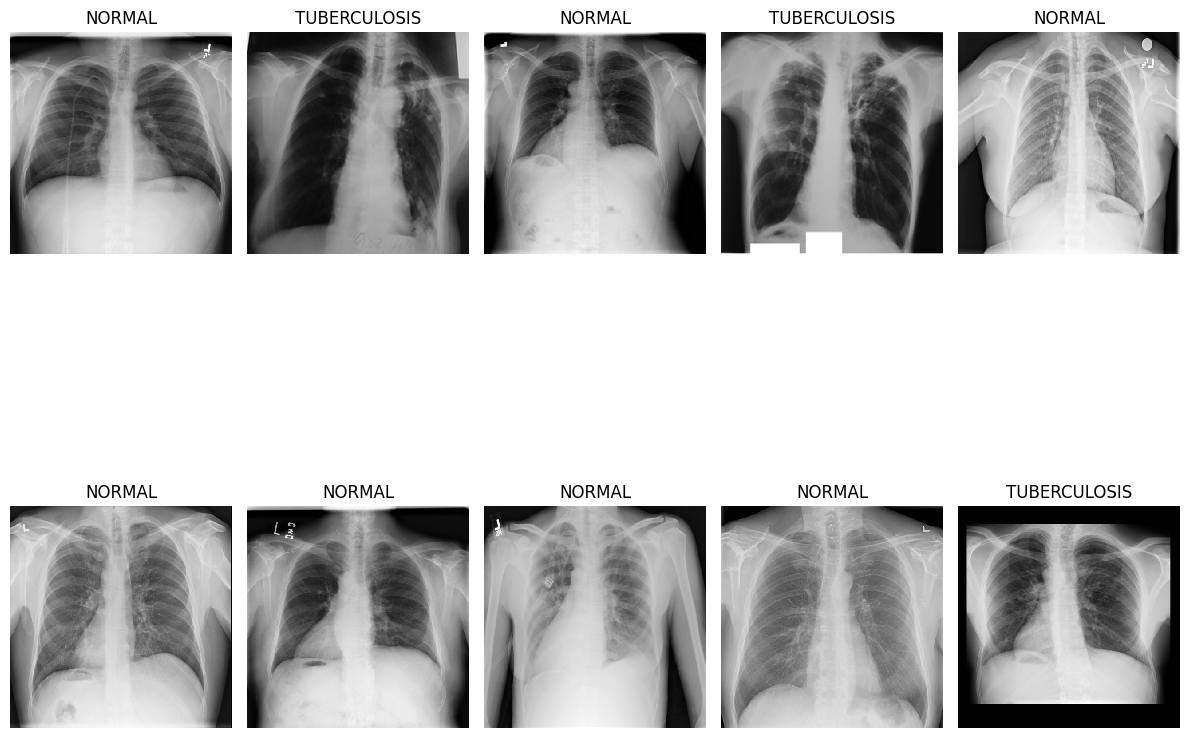

In [13]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 4 Convolutional Neural Network

## 4.1 Necessary Imports

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 4.2 CNN Architecture

In [15]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Compile

In [16]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model Summary

In [17]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 498, 498, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 247, 247, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 123, 123, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 121, 121, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,467,137 (5.60 MB)

 Trainable params: 1,467,137 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Visualize CNN model

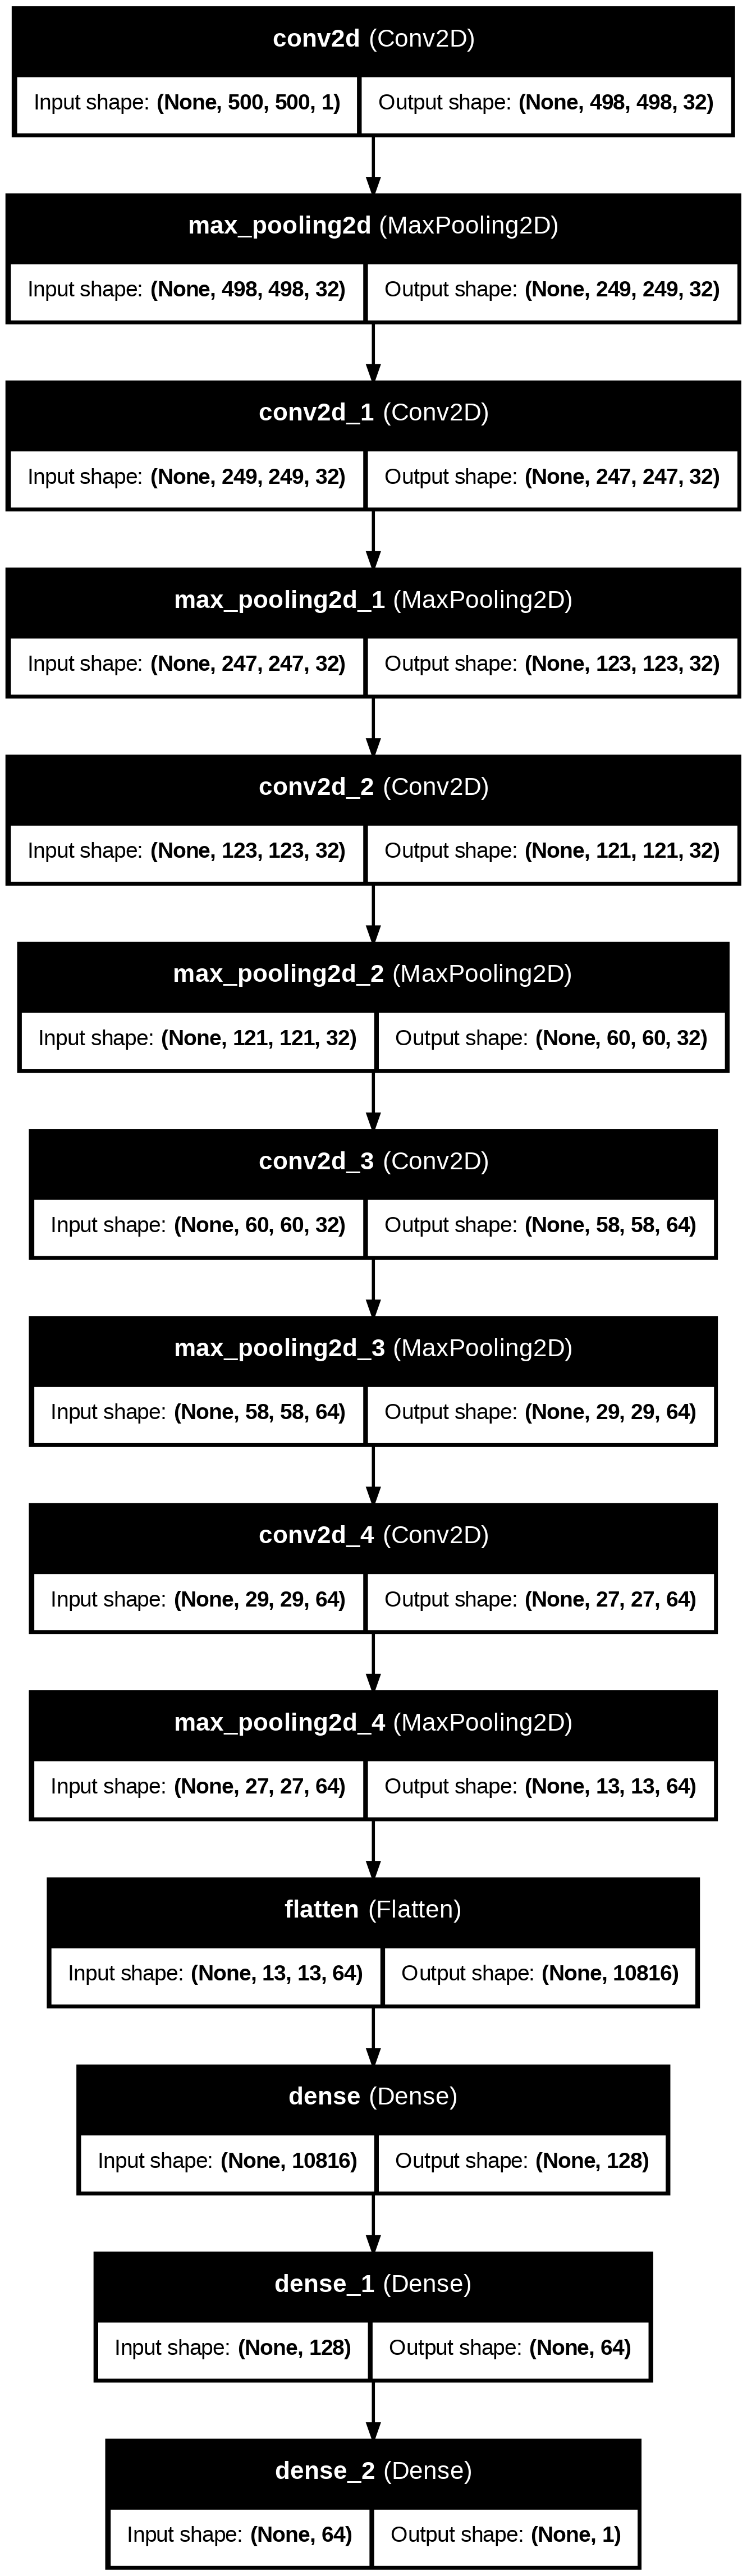

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 4.3 Fit the model

Defining callback list

In [19]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

Assigning Class Weights

In [28]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.array(train.classes)
weights = compute_class_weight(
    class_weight="balanced",  # Correct parameter format
    classes=np.unique(class_labels),
    y=class_labels
)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.5997959183673469, 1: 3.005112474437628}


Training

In [29]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.7714 - loss: 0.5526 - val_accuracy: 0.7619 - val_loss: 0.4235 - learning_rate: 0.0010
Epoch 2/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 197ms/step - accuracy: 0.8726 - loss: 0.2645 - val_accuracy: 0.9060 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 3/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - accuracy: 0.9145 - loss: 0.1956 - val_accuracy: 0.8893 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 4/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - accuracy: 0.9344 - loss: 0.1573 - val_accuracy: 0.9440 - val_loss: 0.1634 - learning_rate: 0.0010
Epoch 5/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - accuracy: 0.9500 - loss: 0.1277 - val_accuracy: 0.9619 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 6/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.9623 - loss: 0.1118 - val_accuracy: 0.9571 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 7/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 193ms/step - accuracy: 0.9

# 5 Evaluate

<Axes: >

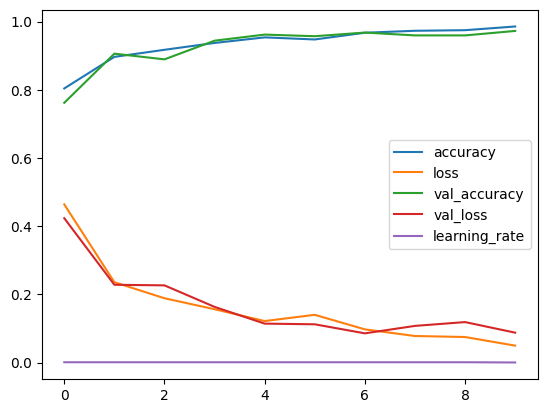

In [30]:
pd.DataFrame(cnn.history.history).plot()

In [31]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9777 - loss: 0.0663
The testing accuracy is : 98.0997622013092 %


In [32]:
preds = cnn.predict(test,verbose=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step


In [33]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Confussion Matrix

<Axes: >

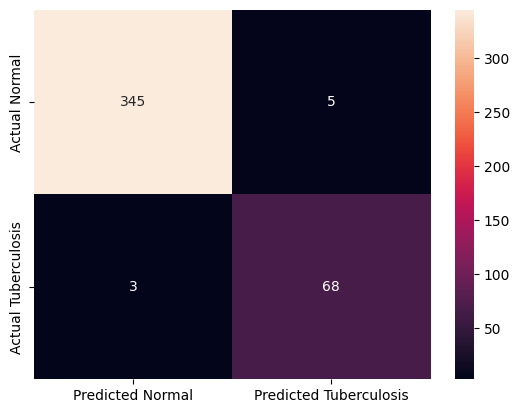

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

Classification Report

In [35]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       350
TUBERCULOSIS       0.93      0.96      0.94        71

    accuracy                           0.98       421
   macro avg       0.96      0.97      0.97       421
weighted avg       0.98      0.98      0.98       421



(421, 500, 500, 1)
(421,)


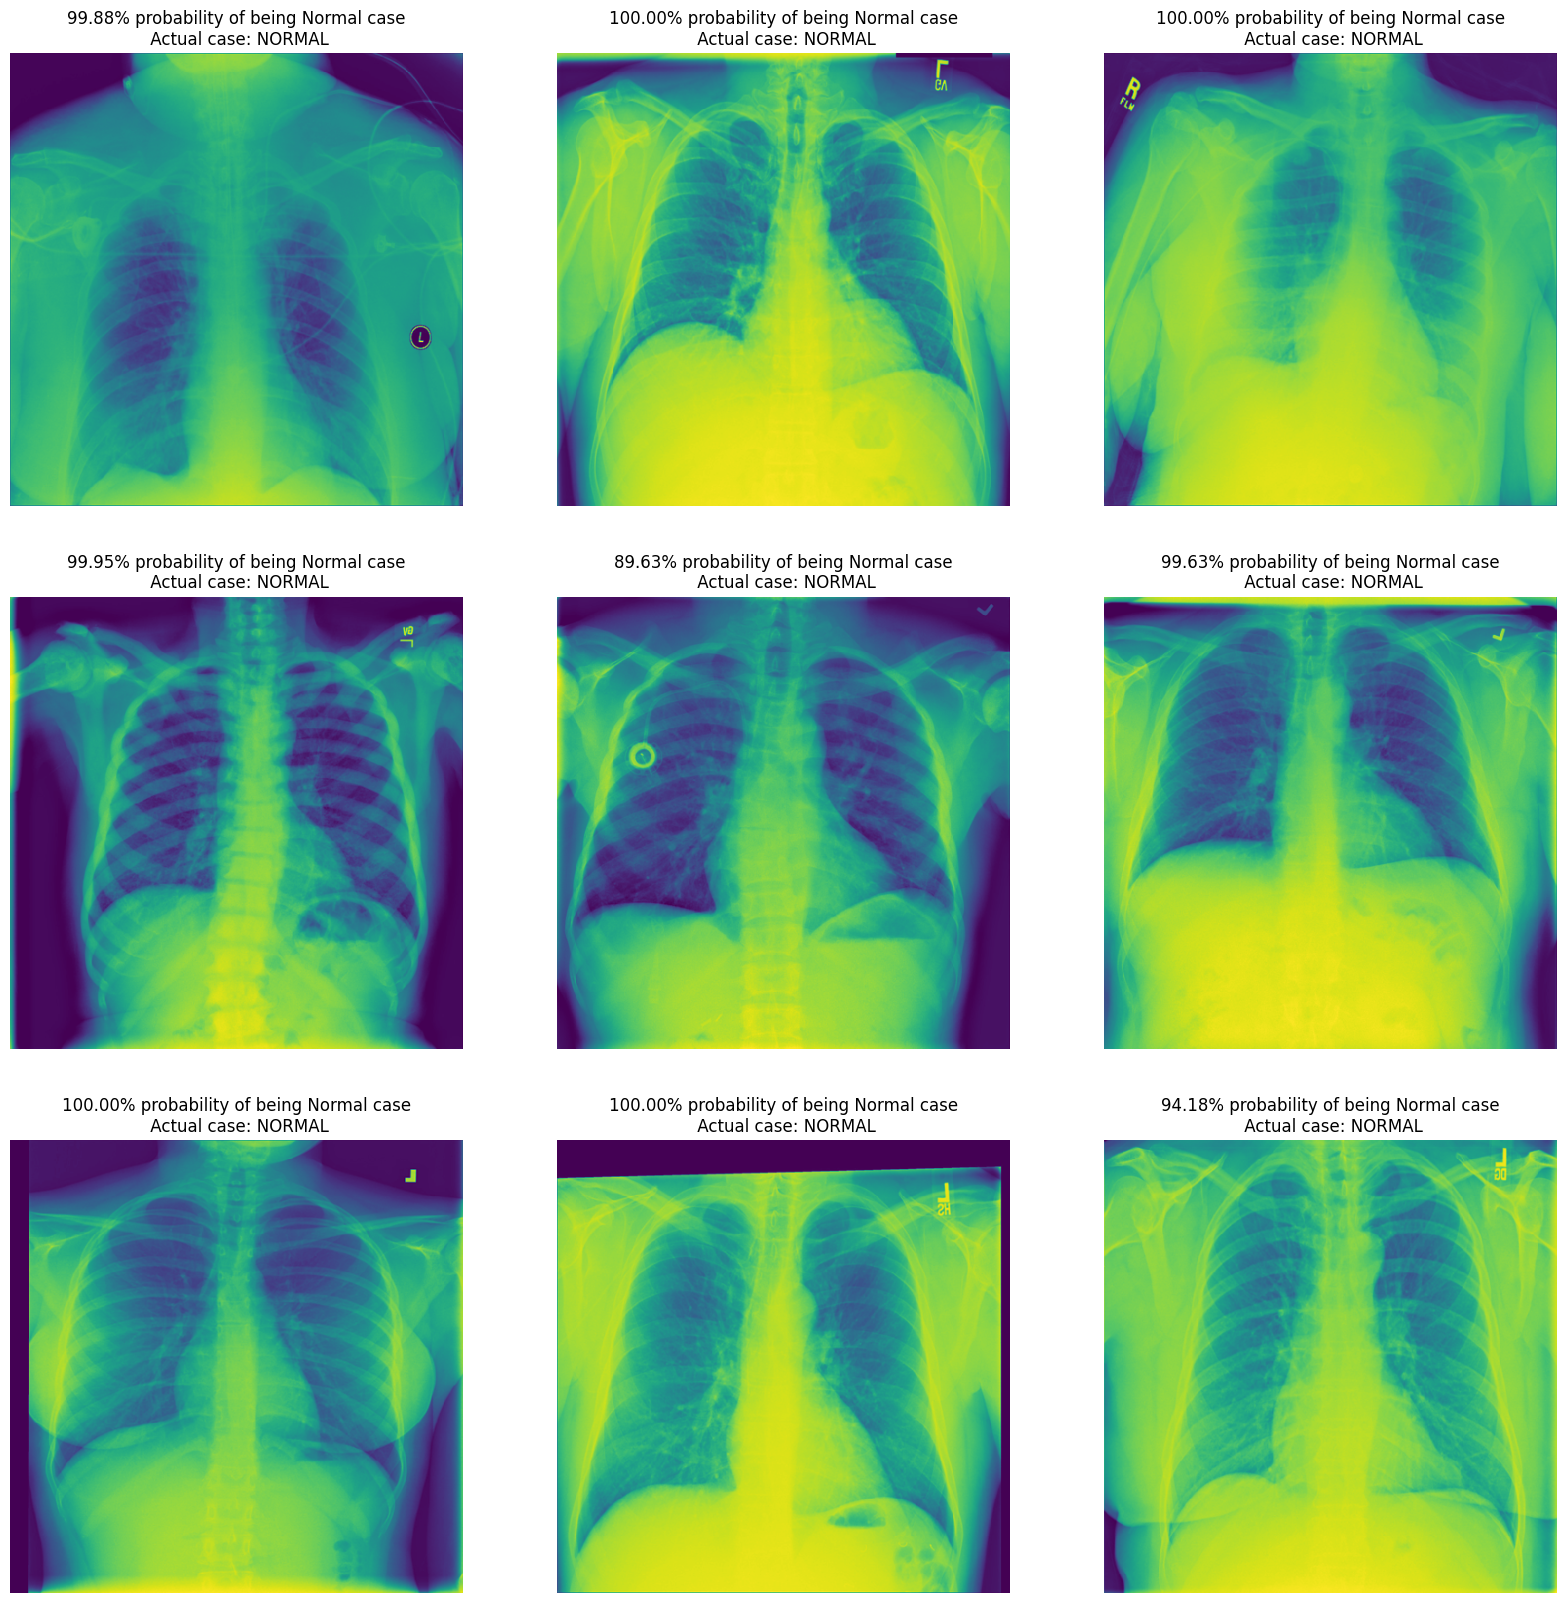

In [38]:
# Reset test generator
test.reset()

# Extract images and labels without shuffling
x = np.concatenate([next(test)[0] for i in range(len(test))])
y = np.concatenate([next(test)[1] for i in range(len(test))])

print(x.shape)
print(y.shape)

# Dictionary for class labels
dic = {0: 'NORMAL', 1: 'TUBERCULOSIS'}

plt.figure(figsize=(20, 20))

# Iterate and plot images
for i in range(0 + 228, 9 + 228):
    plt.subplot(3, 3, (i - 228) + 1)

    if preds[i, 0] >= 0.5:
        out = ('{:.2%} probability of being Tuberculosis case'.format(preds[i][0]))
    else:
        out = ('{:.2%} probability of being Normal case'.format(1 - preds[i][0]))

    plt.title(out + "\n Actual case: " + dic.get(np.argmax(y[i])))  # Ensure correct label extraction
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')

plt.show()
